In [ ]:
%run C:\Users\Omar\Intern_Final_Project\notebooks\Data_Cleaning\Features_Selection.ipynb

### *cross validation*

*We will keep the last 16 rows of the dataset and do a Rolling Moving Origin of step size of 4*


*lets explain this visually*

In [5]:
from sklearn.model_selection import TimeSeriesSplit


In [6]:
test_data_red=df_red[-16:]
#####
X = test_data_red.drop("price",axis=1)
y = test_data_red["price"]
date=test_data_red.reset_index()["week_end_dt"]
tscv = TimeSeriesSplit(n_splits=3,max_train_size=16,test_size=4,gap=0)
for i, (train_index, test_index) in enumerate(tscv.split(X)):
     print(f"Fold {i}:")
     print(f"  Train: index={train_index}")
     print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[0 1 2 3]
  Test:  index=[4 5 6 7]
Fold 1:
  Train: index=[0 1 2 3 4 5 6 7]
  Test:  index=[ 8  9 10 11]
Fold 2:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11]
  Test:  index=[12 13 14 15]


The above code out come expresess how the cross validation works ,
1st fold : we consider the 4 intial points as train data and the next 4 points as test data
2ns fold : the test points from the prevuoys fold we be appened to the new train points asnd new points ahead are test points
3rd fold : works as metioned above

The below chart is ease the process:


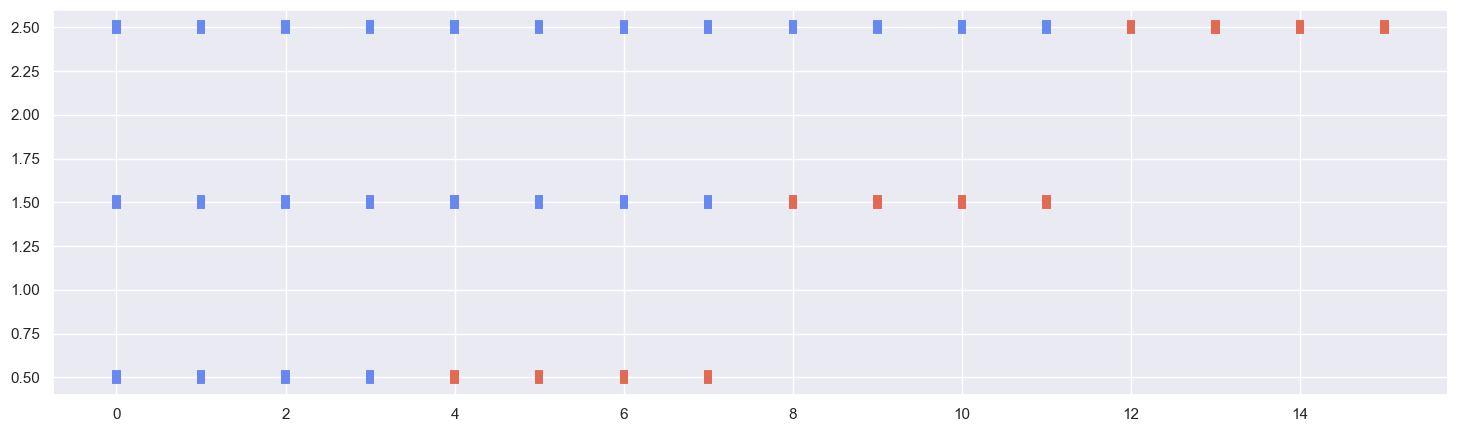

In [7]:
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(cv, n_splits, X, y):
    fig, ax = plt.subplots(1, 1, figsize = (18, 5))
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=10, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)
        
plot_cv_indices(cv=tscv,n_splits=3,X=X,y=y)

---
importing needed libraries

In [8]:
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import plot_tree,plot_importance,XGBRegressor,XGBRFRegressor
from sklearn.linear_model import LinearRegression,LogisticRegression,SGDRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from lightgbm.sklearn import LGBMRegressor
import warnings                                  
warnings.filterwarnings('ignore')

In [9]:
def data_scale():   
     scaler = StandardScaler()
     for col in df_red:
           if col not in ["price"]:
                  df_red[col]=scaler.fit_transform(df_red[[col]])

     for col in df_green:
           if col not in ["price"]:
                  df_green[col]=scaler.fit_transform(df_green[[col]])

     for col in df_yellow:
           if col not in ["price"]:
                  df_yellow[col]=scaler.fit_transform(df_yellow[[col]])             


data_scale()

In [10]:
def train_test(data):
    tscv = TimeSeriesSplit(n_splits=4,max_train_size=16,test_size=4,gap=0)
    mae_scores = []
    y_pred_results=[]

    models_names=["DecisionTreeRegressor","RandomForestRegressor","SVR()","LinearRegression","XGBRegressor_boo",
                  "XGBRFRegressor_boo","AdaBoostRegressor_boo","LGBMRegressor_boo","CatBoostRegressor_boo"]
              
    models=[DecisionTreeRegressor(random_state=0),RandomForestRegressor(random_state=0),SVR(),LinearRegression(),XGBRegressor(random_state=0),
        XGBRFRegressor(random_state=0),AdaBoostRegressor(random_state=0),LGBMRegressor(force_row_wise=True),CatBoostRegressor()]


    test_data=data[-20:]
    time_series_data = test_data.values

    for model in models:
              for train_index, test_index in tscv.split(time_series_data):
                                  X_train, y_train = time_series_data[train_index, 1:], time_series_data[train_index, 0]
                                  X_test, y_test = time_series_data[test_index, 1:], time_series_data[test_index, 0]

                                  model.fit(X_train, y_train)
                                  y_pred = model.predict(X_test)
                                  y_pred_results.append(y_pred)
                                  mae = np.mean(mean_absolute_error(y_test, y_pred))
                                  mae_scores.append(mae)    
                                  outcome=pd.concat([pd.DataFrame(pd.DataFrame(y_pred_results[0:4]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[4:8]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[8:12]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[12:16]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[16:20]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[20:24]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[24:28]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[28:32]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[32:36]).stack().reset_index(drop=True))],axis=1)
                                  new_date_index=pd.date_range(start="2023-07-16",end="2023-10-29",freq="W")
                                  new_date_index=pd.DataFrame({"date":new_date_index})
                                  outcome.columns=models_names
                                  outcome_all=pd.concat([outcome,new_date_index],axis=1).set_index("date")

                                  outcome_mae=pd.concat([pd.DataFrame(pd.DataFrame(mae_scores[0:4]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[4:8]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[8:12]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[12:16]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[16:20]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[20:24]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[24:28]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[28:32]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[32:36]).stack().reset_index(drop=True))],axis=1)
                                  outcome_mae.columns=models_names
                                  
                                  




    return outcome_all,outcome_mae        

In [ ]:

df_red_outcomes=train_test(data=df_red)
df_green_outcomes=train_test(data=df_green)
df_yellow_outcomes=train_test(data=df_yellow)

In [12]:
pd.DataFrame(df_red_outcomes[1].mean(),columns=['score']).reset_index().sort_values(by="score").T

,6,5,2,4,8,1,0,3,7
index,AdaBoostRegressor_boo,XGBRFRegressor_boo,SVR(),XGBRegressor_boo,CatBoostRegressor_boo,RandomForestRegressor,DecisionTreeRegressor,LinearRegression,LGBMRegressor_boo
score,2.242544,2.263427,2.390601,2.397107,2.432192,2.449592,2.579155,2.64386,2.690026


In [13]:
pd.DataFrame(df_green_outcomes[1].mean(),columns=['score']).reset_index().sort_values(by="score").T

,6,4,5,0,2,1,8,3,7
index,AdaBoostRegressor_boo,XGBRegressor_boo,XGBRFRegressor_boo,DecisionTreeRegressor,SVR(),RandomForestRegressor,CatBoostRegressor_boo,LinearRegression,LGBMRegressor_boo
score,1.999644,2.023283,2.027003,2.068038,2.072525,2.080522,2.092057,2.182475,2.287597


In [14]:
pd.DataFrame(df_yellow_outcomes[1].mean(),columns=['score']).reset_index().sort_values(by="score").T

,0,6,3,2,1,5,4,8,7
index,DecisionTreeRegressor,AdaBoostRegressor_boo,LinearRegression,SVR(),RandomForestRegressor,XGBRFRegressor_boo,XGBRegressor_boo,CatBoostRegressor_boo,LGBMRegressor_boo
score,2.940008,2.955728,3.079869,3.09313,3.16896,3.169931,3.181098,3.217818,3.608196


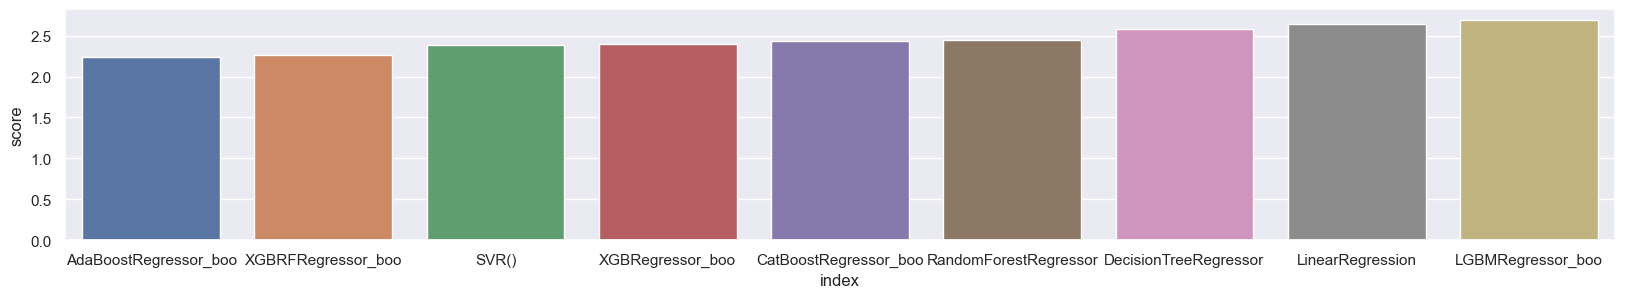

In [15]:
fig, ax = plt.subplots(1, 1, figsize = (20,3))
sns.barplot(data=pd.DataFrame(df_red_outcomes[1].mean(),columns=['score']).reset_index().sort_values(by="score"),x="index",y="score");

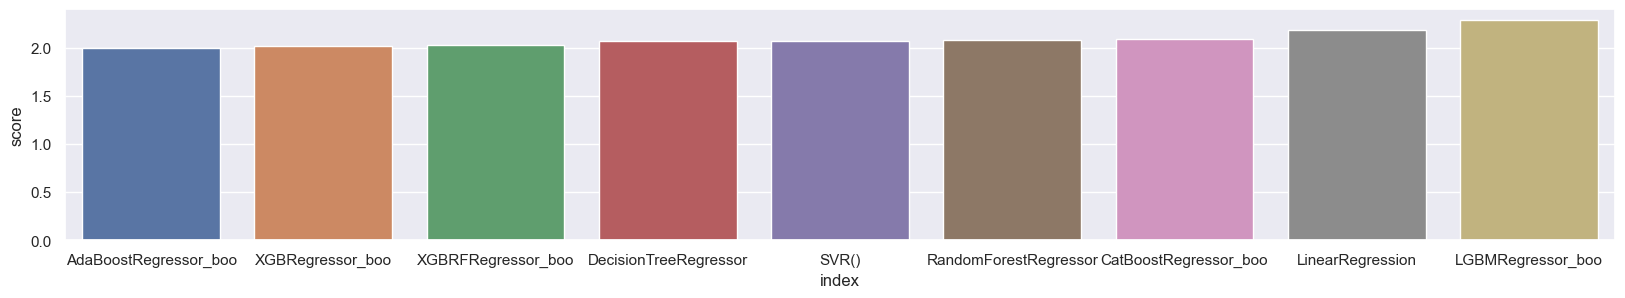

In [16]:
fig, ax = plt.subplots(1, 1, figsize = (20,3))
sns.barplot(data=pd.DataFrame(df_green_outcomes[1].mean(),columns=['score']).reset_index().sort_values(by="score"),x="index",y="score");

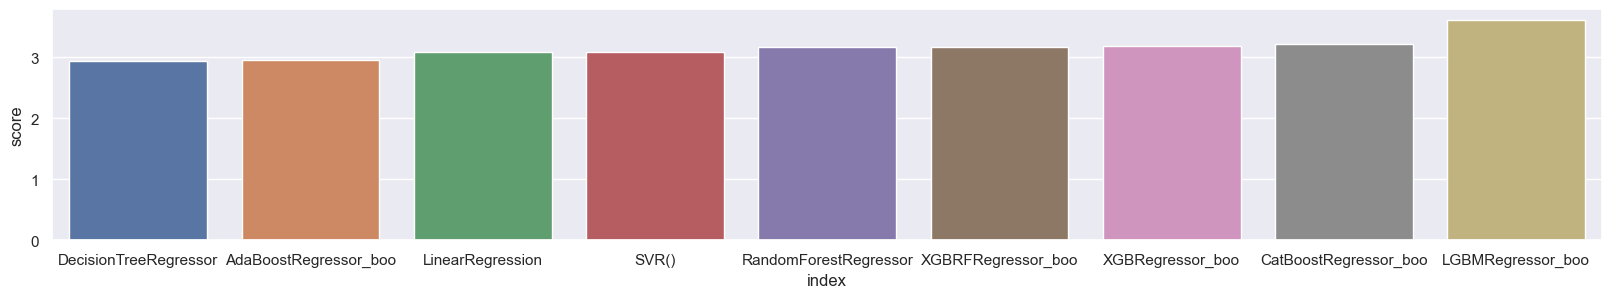

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (20,3))
sns.barplot(data=pd.DataFrame(df_yellow_outcomes[1].mean(),columns=['score']).reset_index().sort_values(by="score"),x="index",y="score");

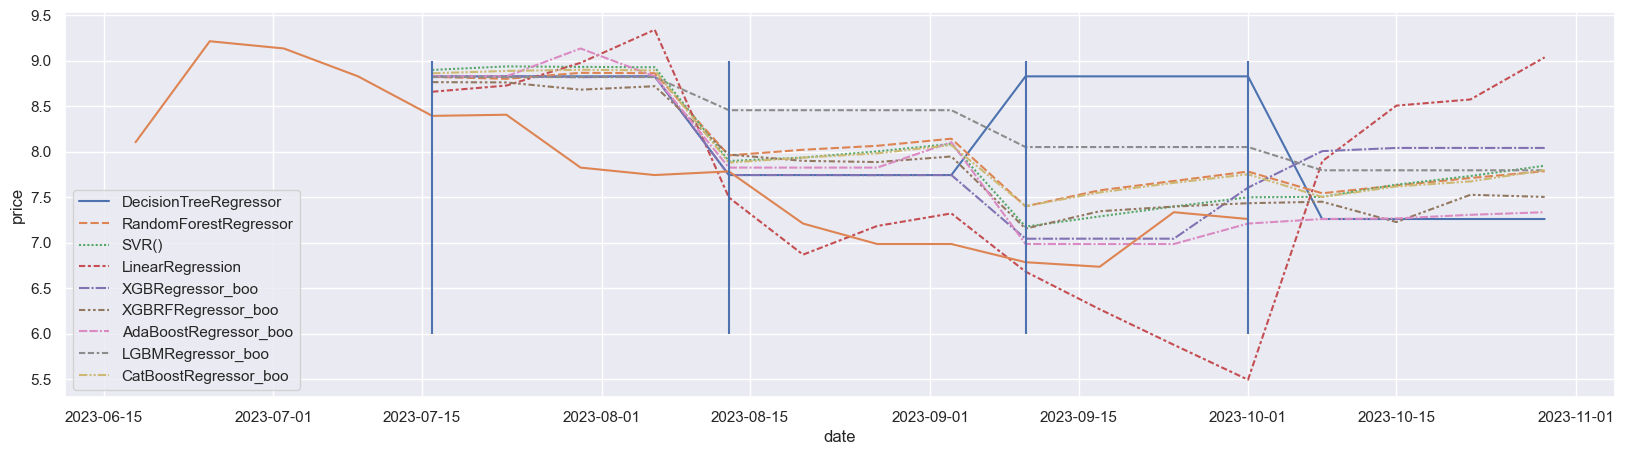

In [23]:
fig, ax = plt.subplots(figsize = (20,5));
y_min = 6
y_max = 9
sns.lineplot(df_red_outcomes[0]);
sns.lineplot(df_red[-20:-4]["price"]);
ax.vlines(x=["2023-07-16","2023-08-13","2023-09-10","2023-10-01"],ymax=y_max,ymin=y_min)

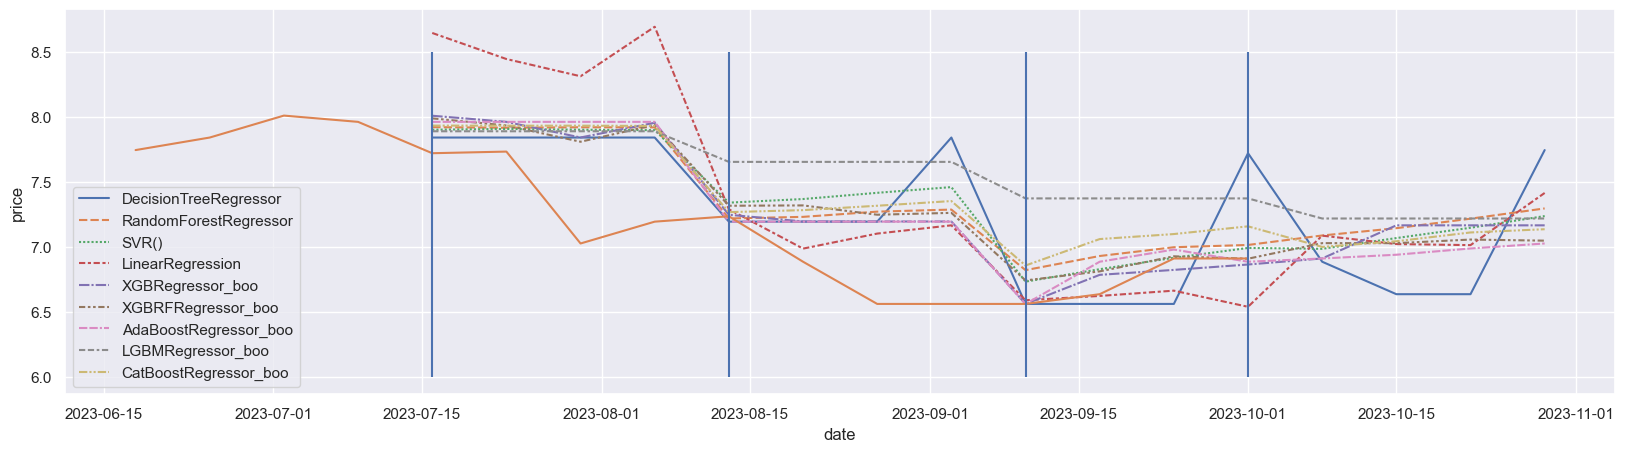

In [19]:
fig, ax = plt.subplots(figsize = (20,5));
y_min = 6
y_max = 8.5
sns.lineplot(df_green_outcomes[0]);
sns.lineplot(df_green[-20:-4]["price"]);
ax.vlines(x=["2023-07-16","2023-08-13","2023-09-10","2023-10-01"],ymax=y_max,ymin=y_min)

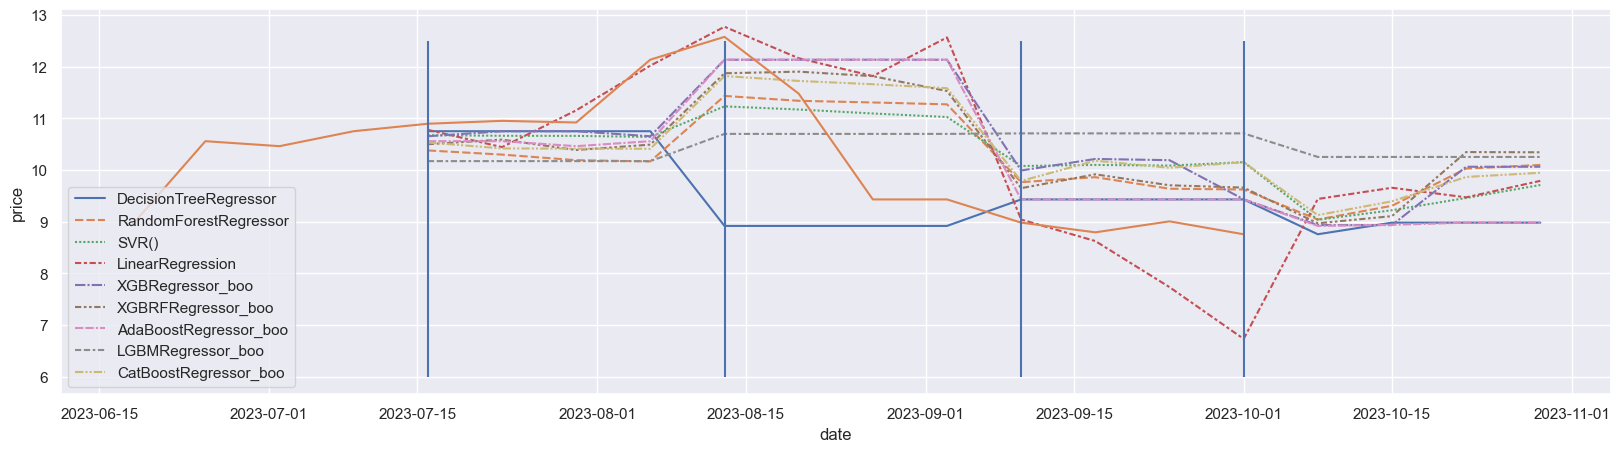

In [20]:
fig, ax = plt.subplots(figsize = (20,5));
y_min = 6 
y_max = 12.5
sns.lineplot(df_yellow_outcomes[0]);
sns.lineplot(df_yellow[-20:-4]["price"]);
ax.vlines(x=["2023-07-16","2023-08-13","2023-09-10","2023-10-01"],ymax=y_max,ymin=y_min)

---

## *Hyperparamers tunning*

In [21]:
from hyperopt import fmin,tpe,STATUS_OK,Trials,hp

In [43]:
space = {
    'max_depth': hp.choice("max_depth", np.arange(1,20,1)),
    'eta'      : hp.uniform("eta", 0, 1),
    'gamma'    : hp.uniform("gamma", 0, 1),
    'colsample_bytree': hp.uniform("colsample_bytree", 0.5,1),
    'colsample_bynode': hp.uniform("colsample_bynode", 0.5,1), 
    'colsample_bylevel': hp.uniform("colsample_bylevel", 0.5,1),
    'n_estimators': hp.choice("n_estimators", np.arange(100,1000,10)),
    'seed' : 44 }

In [46]:
def objective(space):
   test_data=df_red[-20:]
   time_series_data = test_data.values
   for train_index, test_index in tscv.split(time_series_data):
                                  X_train, y_train = time_series_data[train_index, 1:], time_series_data[train_index, 0]
                                  X_test, y_test = time_series_data[test_index, 1:], time_series_data[test_index, 0]

                                  model_opt = XGBRegressor(max_depth=int(space['max_depth']),
                                                           eta=float(space['eta']),
                                                           gamma=float(space['gamma']),
                                                           colsample_bytree=float(space['colsample_bytree']),
                                                           colsample_bynode=float(space['colsample_bynode']),
                                                           colsample_bylevel=float(space['colsample_bylevel']),
                                                           n_estimators=int(space['n_estimators']),
                                                           seed=int(space['seed']))    
                                                             
                                  model_opt.fit(X_train,y_train)
                                  mae_scores =[]
                                  mae=mean_absolute_error(y_test,model_opt.predict(X_test))
                                  mae_scores.append(mae)
                                  mean_mae=np.mean(mae_scores)
                                  return {
                                          'loss': mean_mae,
                                          'status': STATUS_OK
                                          }
   
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100)
print(best)   

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [00:28<00:00,  3.48trial/s, best loss: 0.2817918610626222]
{'colsample_bylevel': 0.5003895572443647, 'colsample_bynode': 0.8729697025734592, 'colsample_bytree': 0.5304374291241513, 'eta': 0.645837443327239, 'gamma': 0.024482298492529878, 'max_depth': 9, 'n_estimators': 32}


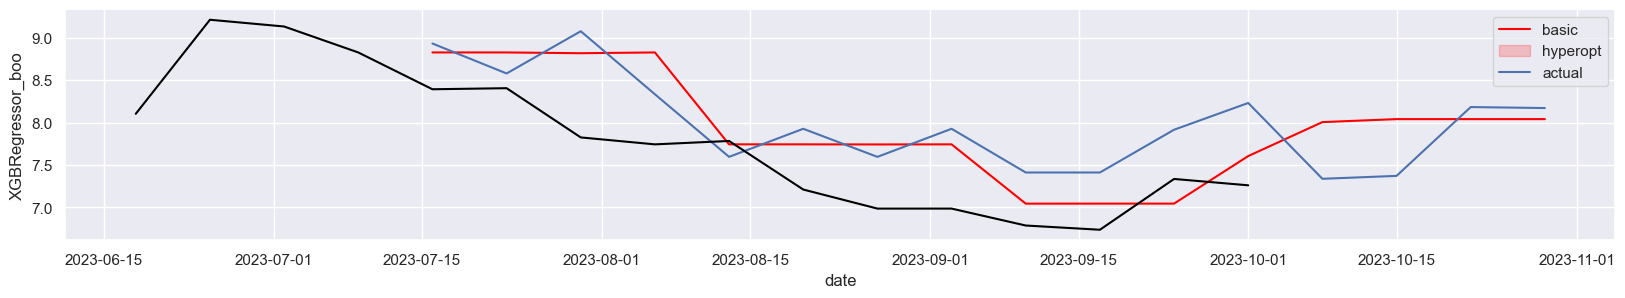

In [60]:
y_pred_results=[]
test_data=df_red[-20:]
time_series_data = test_data.values
for train_index, test_index in tscv.split(time_series_data):
                X_train, y_train = time_series_data[train_index, 1:], time_series_data[train_index, 0]
                X_test, y_test = time_series_data[test_index, 1:], time_series_data[test_index, 0]

                RF_Hyop=XGBRegressor(max_depth=int(best['max_depth']),
                                                           eta=float(best['eta']),
                                                           gamma=float(best['gamma']),
                                                           colsample_bytree=float(best['colsample_bytree']),
                                                           colsample_bynode=float(best['colsample_bynode']),
                                                           colsample_bylevel=float(best['colsample_bylevel']),
                                                           n_estimators=int(best['n_estimators'])).fit(X_train,y_train)
                 
                y_pred = RF_Hyop.predict(X_test)
                y_pred_results.append(y_pred)
                outcome=pd.DataFrame(pd.DataFrame(y_pred_results[0:4]).stack().reset_index(drop=True))
                new_date_index=pd.date_range(start="2023-07-16",end="2023-10-29",freq="W")
                new_date_index=pd.DataFrame({"date":new_date_index})
                outcome_all=pd.concat([outcome,new_date_index],axis=1).set_index("date")
                                

fig, ax = plt.subplots(figsize = (20,3));
sns.lineplot(df_red_outcomes[0]['XGBRegressor_boo'],legend=True,color="red");
sns.lineplot(outcome_all,legend=True,color="blue");
sns.lineplot(df_red['price'][-20:-4],legend=True,color="black");      
plt.legend(["basic","hyperopt","actual"])                            